In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal')
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

# Get data

In [4]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
# trn_j.keys()

In [5]:
annotations = pd.DataFrame(trn_j['annotations'])
images = pd.DataFrame(trn_j['images'])
categories = pd.DataFrame(trn_j['categories'])

In [6]:
id2cat = list(categories.name.values)
cat2id = {v:k for k,v in enumerate(id2cat)}

In [7]:
data = (annotations
        .merge(images, how='left', left_on='image_id', right_on='id')
        .merge(categories, how='left', left_on='category_id', right_on='id'))

data = data[data.ignore != 1] # remove ignores
data.reset_index(drop=True, inplace=True)
# data.tail()  # len = 6301

In [8]:
def bb_hw_pandas(x):
    return [x[1], x[0], x[1]+x[3]-1, x[0]+x[2]-1]

In [9]:
# aggregate bounding box arrays and categories per file_name
df = data.groupby(['file_name'])['bbox', 'category_id'].agg(
    {'bbox': lambda y: list(y), 'category_id': lambda x: list(x-1)})

# convert to hw format
df['bbox_fastai'] = df['bbox'].apply(lambda ary: [bb_hw_pandas(x) for x in ary])
# concatenate array and seperate into string
df['bbox_fastai'] = df['bbox_fastai'].apply(lambda ary: ' '.join(str(x) for x in np.concatenate(ary)))
df.head()

bbox  \
file_name                                                       
000012.jpg                              [[155, 96, 196, 174]]   
000017.jpg           [[184, 61, 95, 138], [89, 77, 314, 259]]   
000023.jpg  [[8, 229, 237, 271], [229, 219, 105, 281], [1,...   
000026.jpg                               [[89, 124, 248, 88]]   
000032.jpg  [[103, 77, 272, 106], [132, 87, 65, 36], [194,...   

                   category_id  \
file_name                        
000012.jpg                 [6]   
000017.jpg            [14, 12]   
000023.jpg  [1, 1, 14, 14, 14]   
000026.jpg                 [6]   
000032.jpg      [0, 0, 14, 14]   

                                                  bbox_fastai  
file_name                                                      
000012.jpg                                     96 155 269 350  
000017.jpg                       61 184 198 278 77 89 335 402  
000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...  
000026.jpg                                     124 89 211 336  
000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [10]:
cat_ary = df.category_id.values
cat_ary = np.array([np.array(x) for x in cat_ary])
cat_ary

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [11]:
multi_box_csv = PATH/'tmp/multi_box.csv'

In [14]:
# file_name is the index!!
df.to_csv(multi_box_csv, columns=['bbox_fastai'])

# Helper Functions

In [16]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [17]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

In [18]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [25]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_aug_boxes(ax, im, bbox):
    bb = bbox.reshape(-1,4)
    bb_keep = (bb[:,2]-bb[:,0]>0).nonzero()[0]
    bbs = [bb_hw(o) for o in bb[bb_keep]]
    ax = show_img(im, ax=ax)
    for i,b in enumerate(bbs):
        if(b[2]>0):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    # prs => percentages of certainty
    # thresh => applies to percentages of certainty
    # remove 0 padding that fastai applies to even out tensor shapes
    bb,clas = reshape_and_remove_zeros(bbox,clas)
    # convert to hw
    bb = [bb_hw(o) for o in bb]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [20]:
def reshape_and_remove_zeros(bbox,clas):
    bb = bbox.reshape(-1,4)
    bb_keep = (bb[:,2]-bb[:,0]>0).nonzero()[0]
    return bb[bb_keep],clas[bb_keep]

# Multiple Objects

Need to use the model data set from multi box because 'continuous' flag in ImageClassifierData converts y to floats in the backend and doesn't play nice with a tuple of data (even if it's already in float format b/c it expects csv strings)

In [8]:
# multi_box_csv = PATH/'tmp/multi_box.csv'

In [21]:
f_model = resnet34
sz = 224
bs = 64

In [22]:
tfm_y = TfmType.COORD
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=tfm_y),
            RandomLighting(0.05, 0.05, tfm_y=tfm_y),
            RandomFlip(tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, multi_box_csv, tfms=tfms, bs=bs, continuous=True)

## Check image transforms

In [23]:
x,y = to_np(next(iter(md.aug_dl)))
x = md.val_ds.denorm(x)

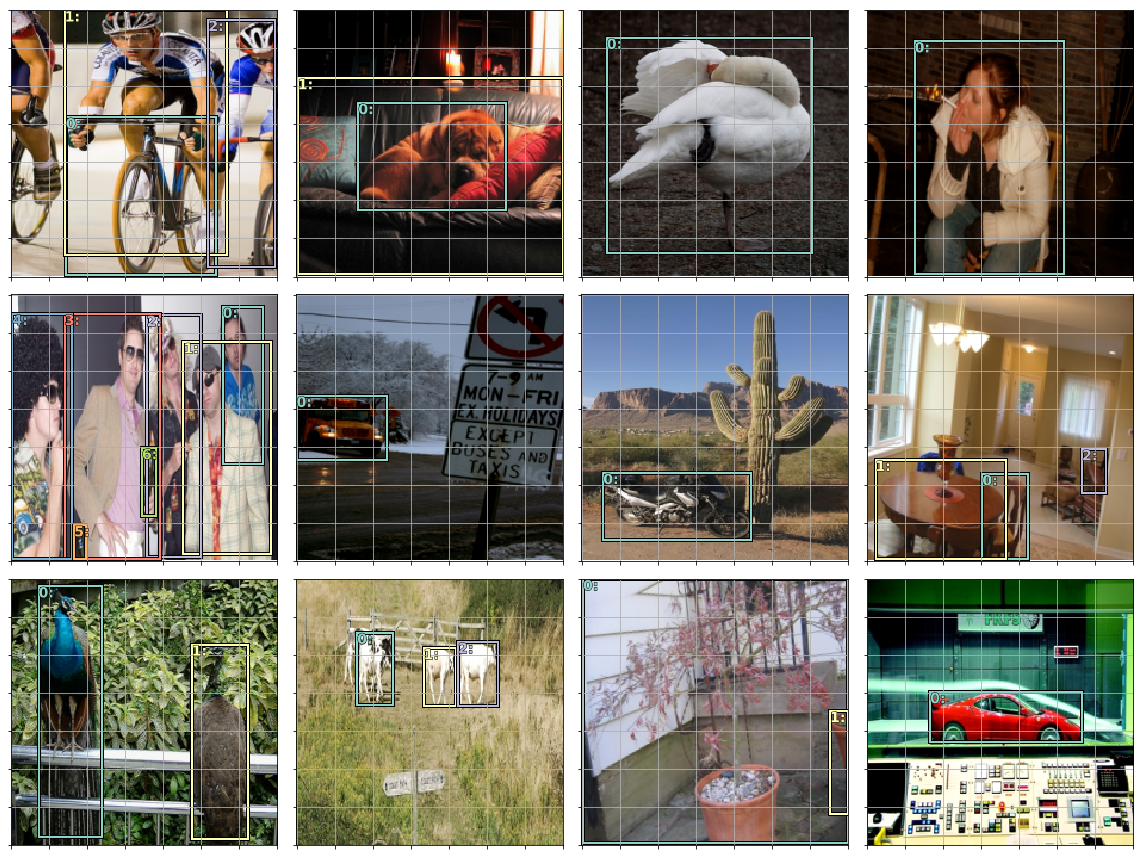

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_aug_boxes(ax, x[i], y[i])
plt.tight_layout()

## Add cat_ary into the dataset (pre-separated into trn/val)

My categories are buggered so I use Jeremy's

In [27]:
idxs = get_cv_idxs(len(cat_ary))
((val_cats, trn_cats),)= split_by_idx(idxs, cat_ary)

In [28]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [29]:
md.trn_dl.dataset = ConcatLblDataset(md.trn_ds, trn_cats)
md.val_dl.dataset = ConcatLblDataset(md.val_ds, val_cats)

## Check datasets

In [30]:
# val
x,y = to_np(next(iter(md.val_dl)))
x = md.val_ds.ds.denorm(x)

In [178]:
# trn
x,y = to_np(next(iter(md.trn_dl)))
x = md.trn_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


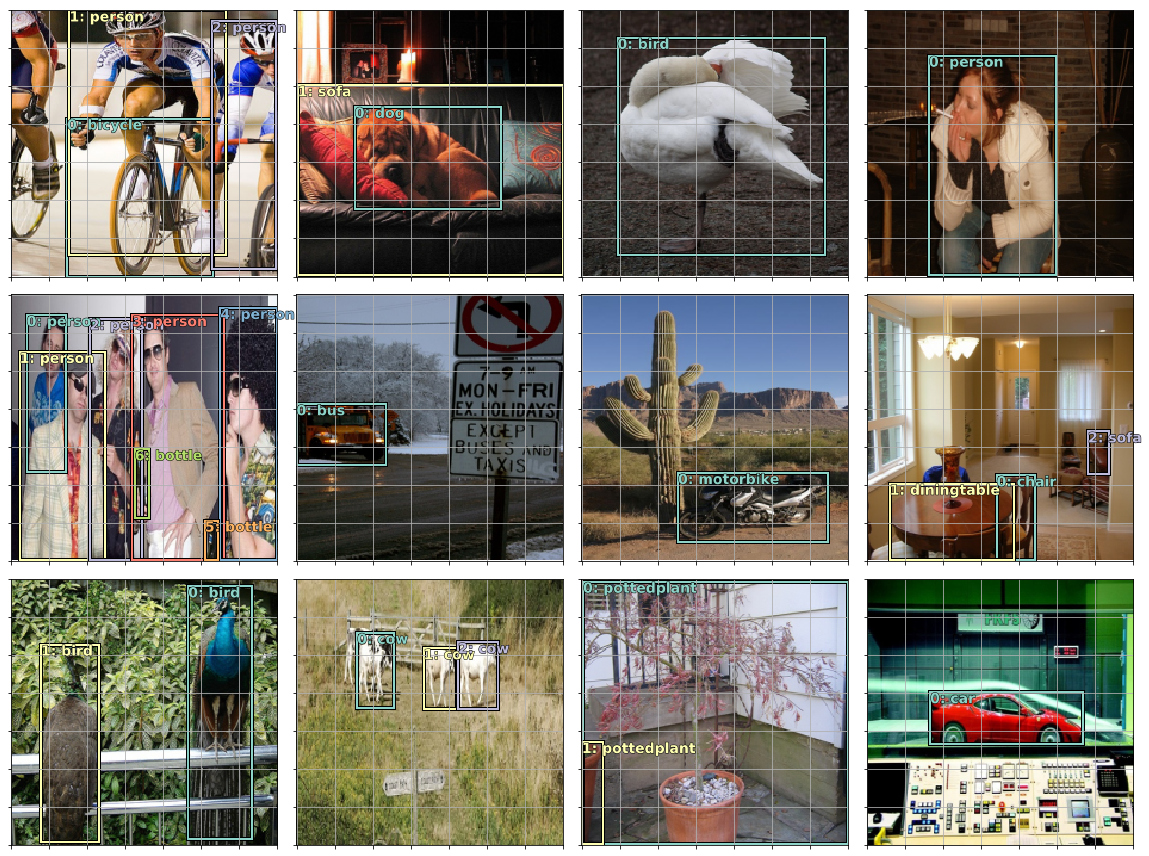

In [31]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Set up Anchors

- anc_grid = how many cells (squared) in the grid
- anc_offset = center offsets
- anc_x = x coordinates for centers
- anc_y = y coordinates for centers
- anc_ctrs - coordinates (x,y) for the grid centers
- anc_sizes - size of the quadrants
- anchors - center (x,y), height, width
- anchors_cnr - lower left (x,y), height, width

In [32]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [33]:
anc_grids = [4,2,1]  # instead of 4,2,1 - http://forums.fast.ai/t/understanding-bouding-boxes-and-receptive-field/14263/2
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k, anchor_scales

(9,
 [(0.7, 0.7),
  (0.7, 0.35),
  (0.35, 0.7),
  (1.0, 1.0),
  (1.0, 0.5),
  (0.5, 1.0),
  (1.3, 1.3),
  (1.3, 0.65),
  (0.65, 1.3)])

In [34]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
# middle coordinates, height, width
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
# top left, bottom right coordinates

anchors.shape

torch.Size([189, 4])

## Custom head

In [35]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self,x):
        return self.drop(self.bn(F.relu(self.conv(x))))

# loss function expects flattened tensor
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

In [36]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        # class
        self.oconv1 = nn.Conv2d(nin, 21*k, 3, padding=1)
        # bounding box
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        # total activation output: n_act == 25
        return [flatten_conv(self.oconv1(x), self.k), flatten_conv(self.oconv2(x), self.k)]

In [56]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        # extra layer of calculation w/out changing geometry  ->  (64,512,7,7)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        # output => (64,256,4,4) as per our anchor boxes
        self.sconv1 = StdConv(256,256, drop=drop)  # each stride 2 conv halves our grid size
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        # collecting anchor boxes from each layer of outputs
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)        # 4x4
        o1c,o1l = self.out1(x)    # save 4x4 anchors
        x = self.sconv2(x)        # 2x2
        o2c,o2l = self.out2(x)    # save 2x2 anchors
        x = self.sconv3(x)        # 1x1
        o3c,o3l = self.out3(x)    # save 1x1 anchors
        return [torch.cat([o1c,o2c,o3c], dim=1),   # concatenate all together
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [195]:
learn.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

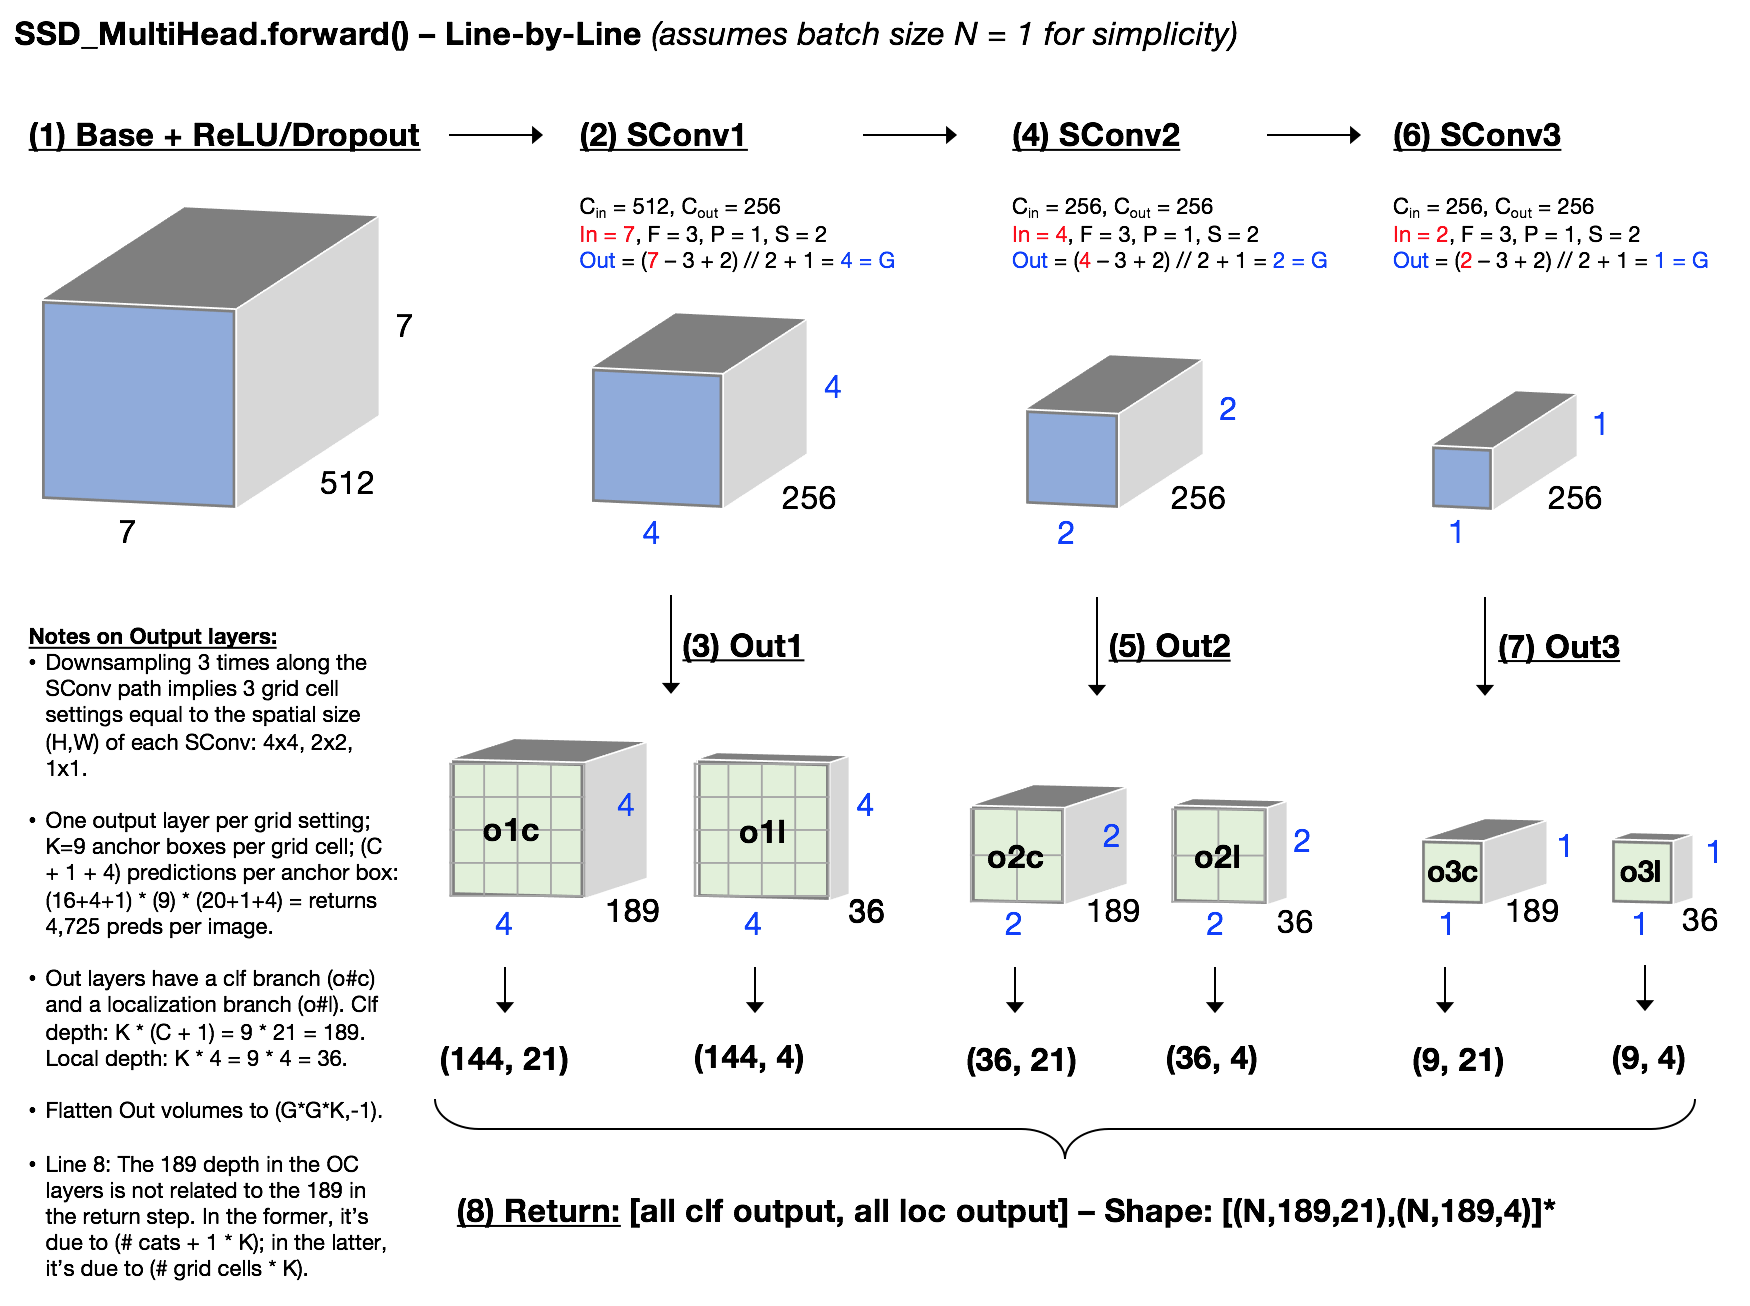

## Loss Function

Network Output: 16 sets of 25 activations, one per anchor box.  
Loss Function: Compare each set of activations (coordinates, class probabilities) with actuals per anchor cell  
    Must first match actuals w/ anchor cells

In [38]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data] 

# Binary x-entropy because a bounding box could have no class associated with it
# Compare to each class and if no matches => background!
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)  # have background (num_classes+1)
        # remove background
        t = V(t[:,:-1].contiguous())  # vector either has 0 or 1 matching elements
        # torch.Size([16, 20])
        x = pred[:,:-1]
        # torch.Size([16, 20])
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [39]:
## Jaccard Index (IoU - intersection over union) - standard function for measuring overlap
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [48]:
# tensor has to be a specific shape but number of labels can vary from image to image
# fastai automatically pads with zeros to accomodate this
# this function is getting rid of the unnecessary zeros
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

# activation to bounding box
# need to convert activations into some way of scaling default anchor box positions
# shift the centers/height and width -> up to half the size of the box
def actn_to_bb(actn, anchors):
    # scale btw -1 and 1
    actn_bbs = torch.tanh(actn)
    # take center of actual anchor boxes (anchors[:,:2]) and move them around
    # according to scaled activations up to half the size of a cell
    actn_centers = anchors[:,:2] + (actn_bbs[:,:2] * grid_sizes/2)
    # do same for height and width
    actn_hw = anchors[:,2:] * (actn_bbs[:,2:]/2+1)
    return hw2corners(actn_centers, actn_hw)

# This combines jaccard overlaps in a way described in the SSD paper
# to assign every anchor box to a ground truth object.
# Row-wise max are mapped as is while column-wise max map if the overlap is >= 0.5
# If neither applies, it is considered to be a cell which contains background.
def map_to_ground_truth(overlaps, print_it=False):
    # overlaps shape: (ground truth objects, number of cells (e.g. 16))
    # row-wise max: each ground truth object wrt each cell => (max jaccard, cell index)
    anchor_overlap, anchor_idx = overlaps.max(1)
    if print_it: print(anchor_overlap)
    # column-wise max: each cell wrt each gt object => (max jaccard, accompanying gt index)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[anchor_idx] = 1.99
    for i,o in enumerate(anchor_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

# handles one item in the batch at a time
def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    # b_c (16,21) - x_class
    # b_bb (16,4) - x_bounding_box
    bbox,clas = get_y(bbox,clas)
    # bbox (# of objects,4)   - y_bounding_box
    # clas (# of objects)     - y_class
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()  # L1
    clas_loss = loss_f(b_c, gt_clas)  # BCE
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    # loops through each image in the minibatch calling ssd_1_loss (for one image)
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        # should these be scaled??
        lls += loc_loss # * 10
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

### Check loss

In [41]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)

In [42]:
preds = learn.model(x)
b_clas,b_bb = preds
b_clas.shape, b_bb.shape

(torch.Size([64, 189, 21]), torch.Size([64, 189, 4]))

In [52]:
ssd_loss(preds, y)

tensor(331.6767, device='cuda:0')

## Training

In [57]:
learn.crit = ssd_loss

In [58]:
learn.lr_find()

 88%|████████▊ | 28/32 [00:18<00:02,  1.54it/s, loss=1.43e+03]

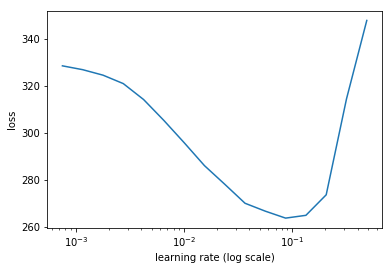

In [59]:
learn.sched.plot(n_skip_end=1)

In [60]:
lr = 1e-2
lrs = np.array([lr/100, lr/10, lr])

In [61]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                           
    0      160.713992 130.52404 
    1      128.949032 101.953937                         
    2      110.845127 91.94921                           
    3      98.473994  88.172699                           


[88.17269897460938]

In [62]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(20,8))

epoch      trn_loss   val_loss                            
    0      97.477101  93.918231 
    1      89.506237  85.321352                           


[85.32135168457032]

In [63]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss                            
    0      86.009582  96.419759 
    1      82.84473   85.02438                            
    2      76.18462   76.871283                           
    3      69.836049  74.001493                           


[74.0014927368164]

In [64]:
learn.save('prefocal-74.00')

## Testing

In [34]:
learn.load('prefocal-74.00')

In [65]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()  # put model in evaluation mode
batch = learn.model(x)
b_clas,b_bb = batch
b_clas.size(),b_bb.size()

(torch.Size([64, 189, 21]), torch.Size([64, 189, 4]))

In [66]:
# ground truth
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas
# notice the bounding box coordinates have all been scaled btw 0 and 1

(tensor([[ 0.6786,  0.4866,  0.9911,  0.6250],
         [ 0.7098,  0.0848,  0.9911,  0.5491],
         [ 0.5134,  0.8304,  0.6696,  0.9063]], device='cuda:0'),
 tensor([  8,  10,  17], device='cuda:0'))

In [67]:
ssd_loss(batch, y)

tensor(79.3098, device='cuda:0')

In [68]:
# converts tensors into numpy and passes them along to show_ground_truth()
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


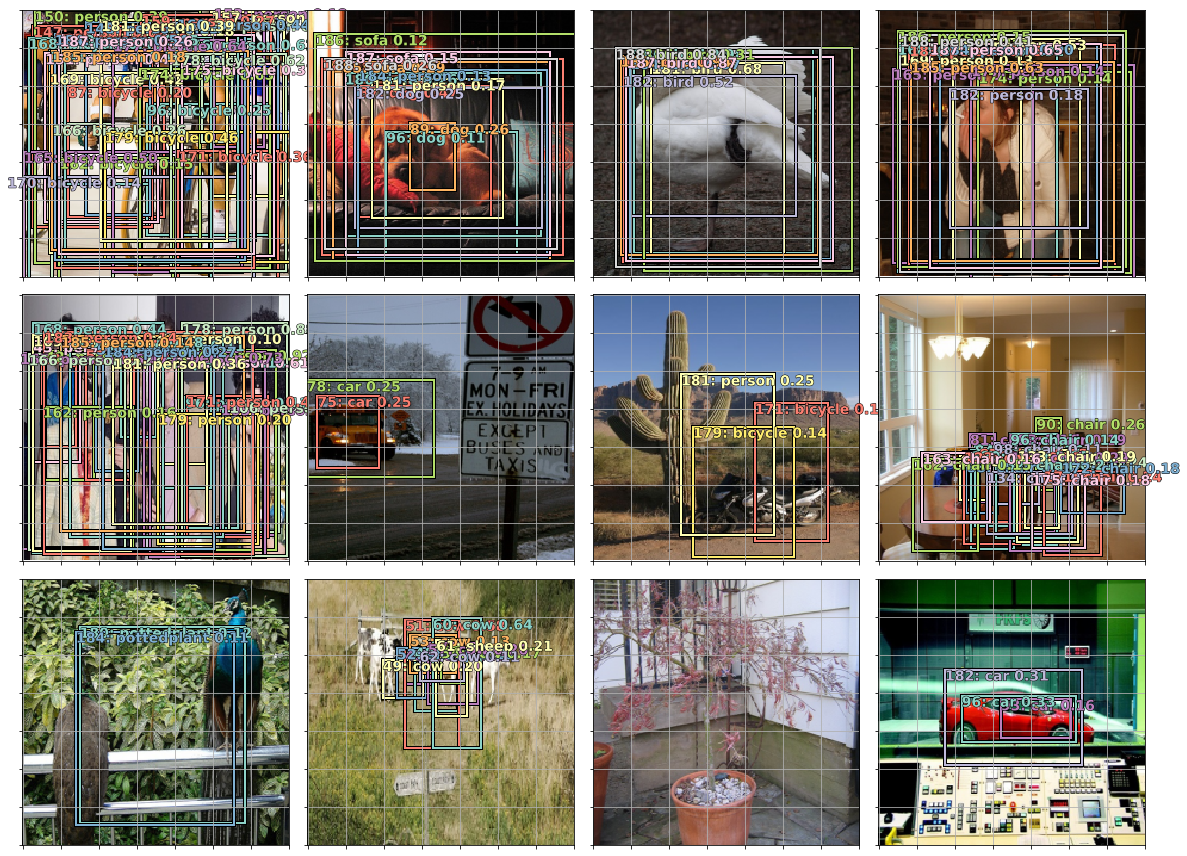

In [71]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
#     ima=md.val_ds.ds.denorm(to_np(x))[idx]
#     bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.1)
plt.tight_layout()

## Focal Loss

Focal loss is just scaled x-entropy loss  
add (1 − pt)^γ to start of the equation

In [72]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [74]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)
ssd_loss(batch, y)

tensor(21.1401, device='cuda:0')

In [75]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      28.559045  6486.808145
    1      26.424919  28.346421                           
    2      24.269525  21.990095                           
    3      22.557806  22.747867                           
    4      21.387488  20.809144                           
    5      20.467062  19.820132                           
    6      19.637168  19.269386                           
    7      18.805163  18.954248                           
    8      18.091703  18.758449                           
    9      17.480796  18.056535                           


[18.056535171508788]

In [76]:
learn.save('foc_lossl0-18.06')

In [77]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      16.812494  18.196032 
    1      16.631467  18.160731                           
    2      16.541049  18.181347                           
    3      16.312196  17.896442                           
    4      16.109945  17.754288                           
    5      15.808895  17.826415                           
    6      15.630392  17.680719                           
    7      15.387921  17.630876                           
    8      15.171363  17.534343                           
    9      15.003574  17.538627                           


[17.538626640319823]

In [78]:
learn.save('foc_loss20-17.54')

In [87]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an er

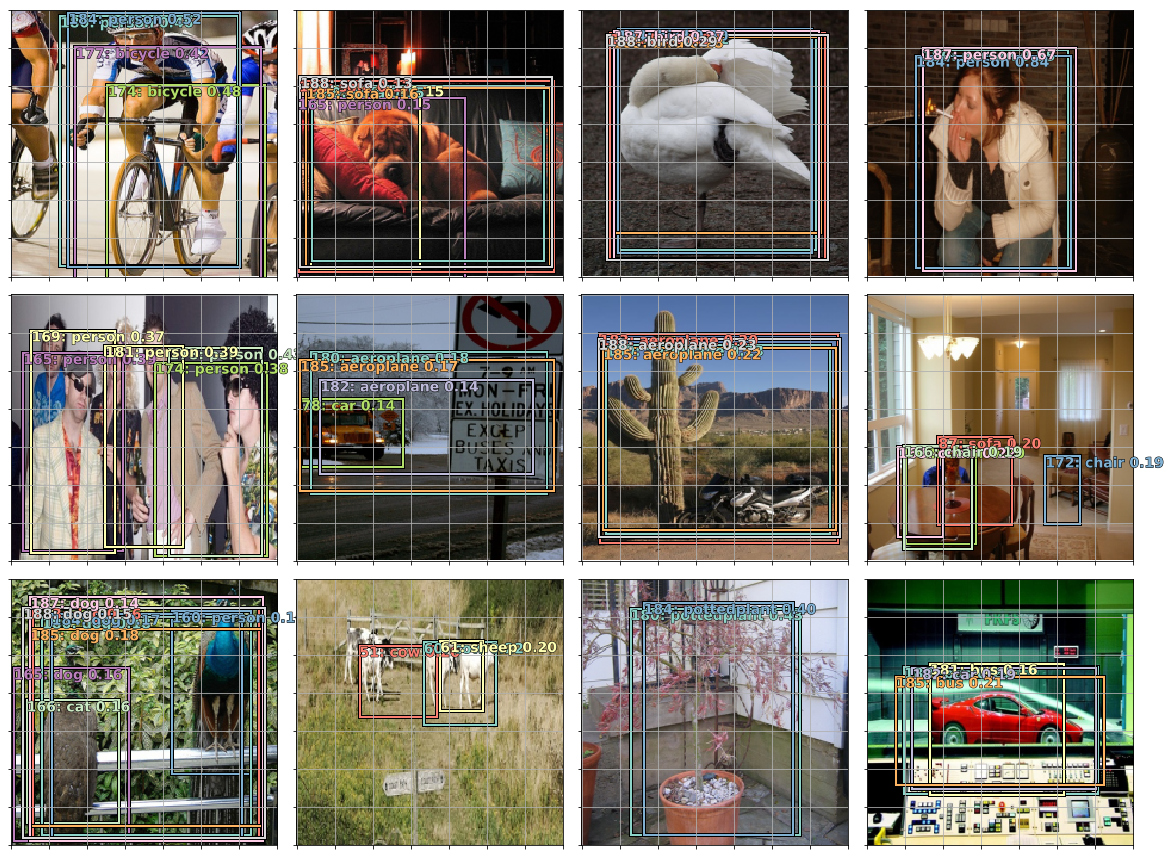

In [88]:
plot_results(0.75)

## Non Maximum Suppression

**pull out just the interesting things** 

Go through every pair of bounding boxes and if they overlap by more than some amount, say 0.5, using Jaccard and they are both predicting the same class, we are going to assume they are the same thing and we are going to pick the one with higher p value.

In [ ]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  
        # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [93]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

ValueError: need at least one array to concatenate

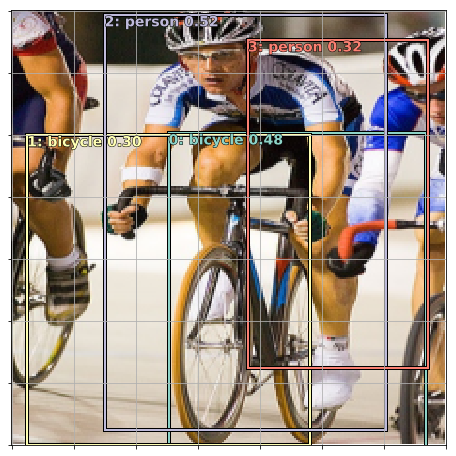

In [94]:
def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)
    
for i in range(12): show_nmf(i)